In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import nilearn
from nltools.file_reader import onsets_to_dm
from nltools.stats import regress, zscore
from nltools.data import Brain_Data, Design_Matrix
from nltools.stats import find_spikes 
from nilearn.plotting import view_img, glass_brain, plot_stat_map
from bids import BIDSLayout, BIDSValidator

/Users/RaulAlvarez/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [15]:
data_dir = 'Localizer'
layout = BIDSLayout(data_dir, derivatives=True)

In [196]:
from nilearn.image import concat_imgs, mean_img

path = "Localizer/derivatives/fmriprep/sub-S01/func/sub-S01_task-localizer_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"

fmri_img = concat_imgs(path)
print(fmri_img.shape)
mean_img = mean_img(fmri_img)
#print(mean_img)


(91, 109, 91, 128)


In [28]:

subject = "S01"
events = pd.read_csv(layout.get(subject=subject, suffix='events')[0].path, sep='\t')
events.head(20)

,onset,duration,trial_type
0,0.0,1,video_computation
1,2.4,1,video_computation
2,8.7,1,horizontal_checkerboard
3,11.4,1,audio_right_hand
4,15.0,1,audio_sentence
5,18.0,1,video_right_hand
6,20.7,1,audio_sentence
7,23.7,1,audio_left_hand
8,26.7,1,video_left_hand
9,29.7,1,audio_sentence


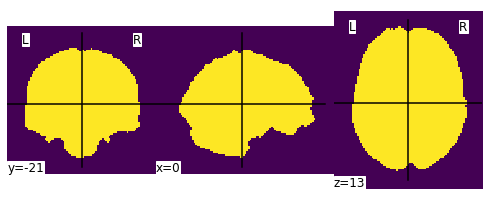

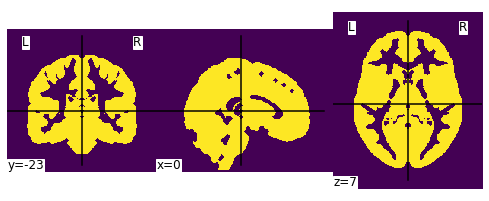

In [188]:
# Mask
from nilearn import plotting

data_mask = fmri_glm.masker_.mask_img_
data_mask.shape
plotting.plot_img(data_mask)

from nilearn.datasets import fetch_icbm152_brain_gm_mask
icbm_mask = fetch_icbm152_brain_gm_mask()
plotting.plot_img(icbm_mask)




In [192]:
# fmriprep mask
m_path = "Localizer/derivatives/fmriprep/sub-S01/func/sub-S01_task-localizer_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
mask2 = concat_imgs(path)
mask2.shape
print(mask2)
#f1_mask2 = mask2[..., 0]
#mean_mask2 = mean_img(mask2)
#plotting.plot_img(f1_mask2)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (91, 109, 91, 128)
affine: 
[[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  4  91 109  91 128   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.  2.  2.  2.  1.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 10463.61
cal_min         : -1056.3788
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknow

In [21]:
from nilearn.glm.first_level import FirstLevelModel

data_dir = 'Localizer'
layout = BIDSLayout(data_dir, derivatives=True)
tr = layout.get_tr()
print(tr)

2.4


In [68]:
fmri_glm = FirstLevelModel(t_r=tr,
                           drift_model='cosine',
                           high_pass=0.007,
                           standardize=False,
                           hrf_model='spm + derivative',
                           slice_time_ref=0.5,
                           smoothing_fwhm=5)

In [255]:
# Getting some movement confounds

c_path = "Localizer/derivatives/fmriprep/sub-S01/func/sub-S01_task-localizer_desc-confounds_regressors.tsv"
confounds = pd.read_csv(c_path, delimiter='\t')
confounds = confounds.fillna(0)
c_keys = confounds.keys()
print(c_keys[:100])
print(c_keys[100:])
confounds = confounds[['white_matter', 'global_signal','framewise_displacement', 'csf', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']] 
confounds.head()

Index(['csf', 'csf_derivative1', 'csf_derivative1_power2', 'csf_power2',
       'white_matter', 'white_matter_derivative1', 'white_matter_power2',
       'white_matter_derivative1_power2', 'global_signal',
       'global_signal_derivative1', 'global_signal_derivative1_power2',
       'global_signal_power2', 'std_dvars', 'dvars', 'framewise_displacement',
       't_comp_cor_00', 't_comp_cor_01', 't_comp_cor_02', 't_comp_cor_03',
       't_comp_cor_04', 'a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02',
       'a_comp_cor_03', 'a_comp_cor_04', 'a_comp_cor_05', 'a_comp_cor_06',
       'a_comp_cor_07', 'a_comp_cor_08', 'a_comp_cor_09', 'a_comp_cor_10',
       'a_comp_cor_11', 'a_comp_cor_12', 'a_comp_cor_13', 'a_comp_cor_14',
       'a_comp_cor_15', 'a_comp_cor_16', 'a_comp_cor_17', 'a_comp_cor_18',
       'a_comp_cor_19', 'a_comp_cor_20', 'a_comp_cor_21', 'a_comp_cor_22',
       'a_comp_cor_23', 'a_comp_cor_24', 'a_comp_cor_25', 'a_comp_cor_26',
       'a_comp_cor_27', 'a_comp_cor_28', 'a

,white_matter,global_signal,framewise_displacement,csf,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
0,4006.007667,3753.537871,0.000000,5164.630182,-0.028014,-0.038885,-0.033840,-0.000634,0.000344,-0.000701
1,4011.819383,3760.408417,0.090243,5178.481411,-0.019273,-0.019809,-0.076608,-0.000541,0.000569,-0.000776
2,4006.766409,3756.426086,0.071067,5161.040643,-0.016559,-0.026117,-0.044713,-0.000805,0.000655,-0.000524
3,4008.586021,3751.566090,0.097295,5150.604178,-0.025758,0.014727,-0.062380,-0.000396,0.000554,-0.000605
4,4007.189291,3746.298200,0.078053,5172.441161,-0.015119,-0.001858,-0.052669,-0.000541,0.000997,-0.000840


In [256]:
fmri_glm = fmri_glm.fit(fmri_img, events, confounds=confounds) #confounds=confounds

In [257]:
design_matrix = fmri_glm.design_matrices_[0]

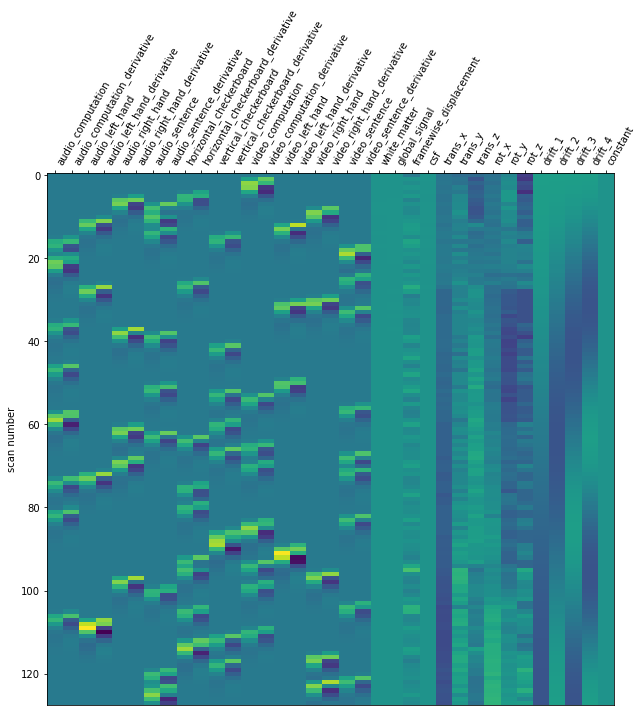

In [258]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(design_matrix)
import matplotlib.pyplot as plt
plt.show()

In [259]:
design_matrix.keys()

Index(['audio_computation', 'audio_computation_derivative', 'audio_left_hand',
       'audio_left_hand_derivative', 'audio_right_hand',
       'audio_right_hand_derivative', 'audio_sentence',
       'audio_sentence_derivative', 'horizontal_checkerboard',
       'horizontal_checkerboard_derivative', 'vertical_checkerboard',
       'vertical_checkerboard_derivative', 'video_computation',
       'video_computation_derivative', 'video_left_hand',
       'video_left_hand_derivative', 'video_right_hand',
       'video_right_hand_derivative', 'video_sentence',
       'video_sentence_derivative', 'white_matter', 'global_signal',
       'framewise_displacement', 'csf', 'trans_x', 'trans_y', 'trans_z',
       'rot_x', 'rot_y', 'rot_z', 'drift_1', 'drift_2', 'drift_3', 'drift_4',
       'constant'],
      dtype='object')

In [260]:
def make_localizer_contrasts(design_matrix):
    """ returns a dictionary of four contrasts, given the design matrix"""

    # first generate canonical contrasts
    contrast_matrix = np.eye(design_matrix.shape[1])
    contrasts = dict([(column, contrast_matrix[i])
                      for i, column in enumerate(design_matrix.columns)])

    contrasts['audio'] = (
        contrasts['audio_left_hand']
        + contrasts['audio_right_hand']
        + contrasts['audio_computation']
        + contrasts['audio_sentence'])

    # one contrast adding all conditions involving instructions reading
    contrasts['video'] = (
        contrasts['video_left_hand']
        + contrasts['video_right_hand']
        + contrasts['video_computation']
        + contrasts['video_sentence'])

    # one contrast adding all conditions involving computation
    contrasts['computation'] = (contrasts['video_computation']
                                + contrasts['audio_computation'])

    # one contrast adding all conditions involving sentences
    contrasts['sentences'] = (contrasts['audio_sentence']
                              + contrasts['video_sentence'])

    # Short dictionary of more relevant contrasts
    contrasts = {
        'left - right button press': (
            contrasts['audio_left_hand']
            - contrasts['audio_right_hand']
            + contrasts['video_left_hand']
            - contrasts['video_right_hand']
        ),
        'right - left button press': (
            - contrasts['audio_left_hand']
            + contrasts['audio_right_hand']
            - contrasts['video_left_hand']
            + contrasts['video_right_hand']
        ),
        
        'audio - video': contrasts['audio'] - contrasts['video'],
        'computation - sentences': (contrasts['computation'] -
                                    contrasts['sentences']
        ),
        'horizontal-vertical': (contrasts['horizontal_checkerboard'] -
                                contrasts['vertical_checkerboard']),
        'audio': contrasts['audio'], 
        'video': contrasts['video'],
        'computation': contrasts['sentences'],
        'sentences': contrasts['sentences'],
        'mov_left': (contrasts['audio_left_hand'] + contrasts['video_left_hand']),
        'mov_right': (contrasts['audio_right_hand'] + contrasts['video_right_hand']),
    }
    return contrasts

contrasts = make_localizer_contrasts(design_matrix)
contrasts.keys()

dict_keys(['left - right button press', 'right - left button press', 'audio - video', 'computation - sentences', 'horizontal-vertical', 'audio', 'video', 'computation', 'sentences', 'mov_left', 'mov_right'])

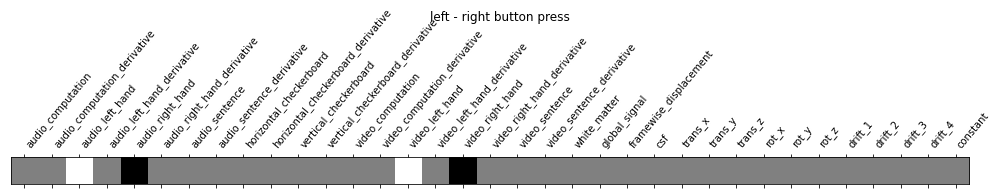

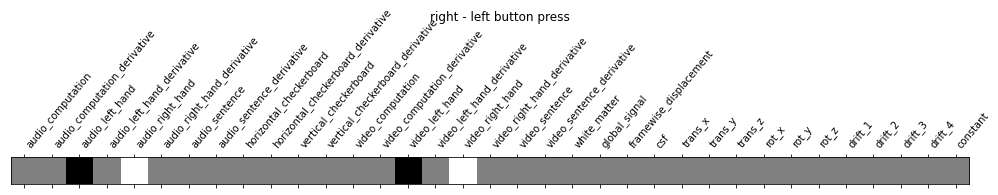

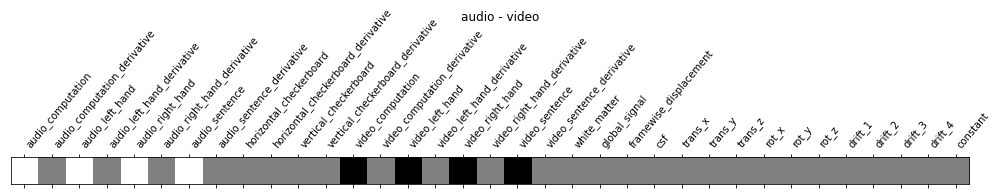

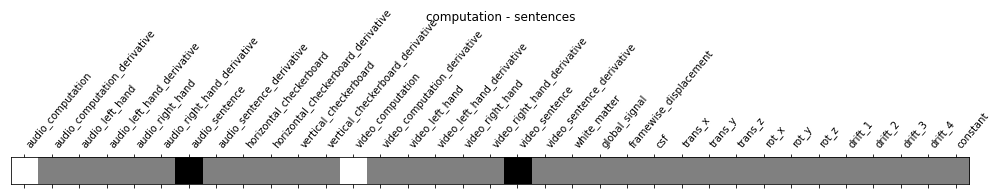

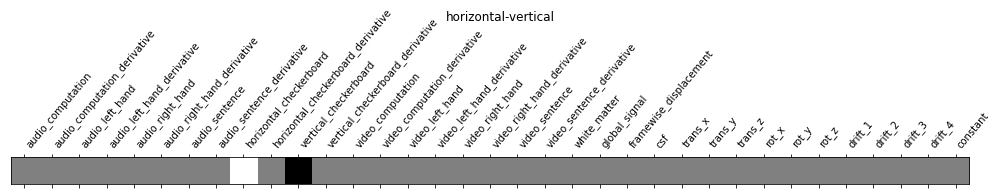

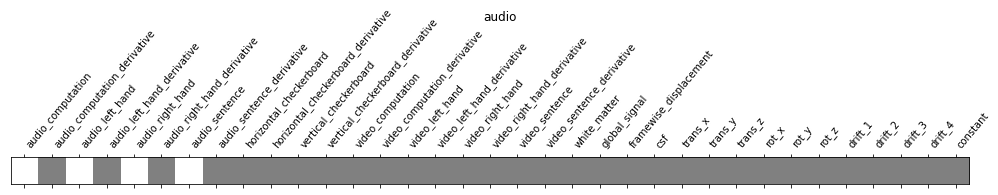

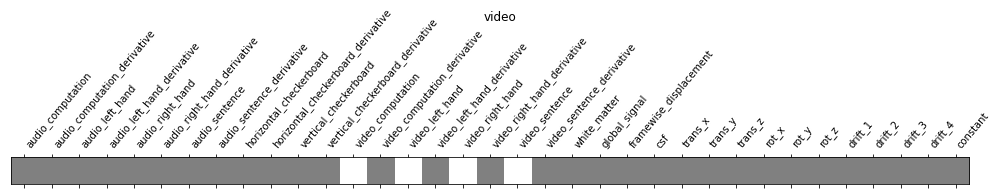

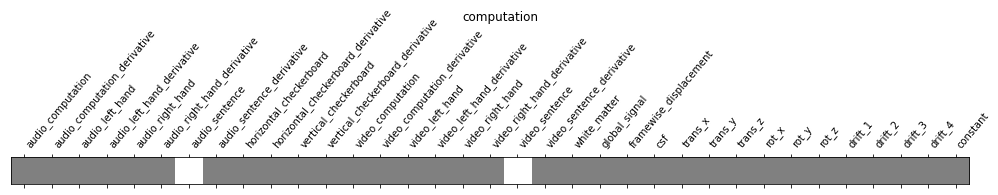

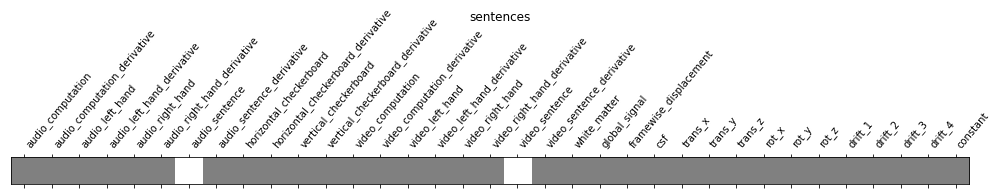

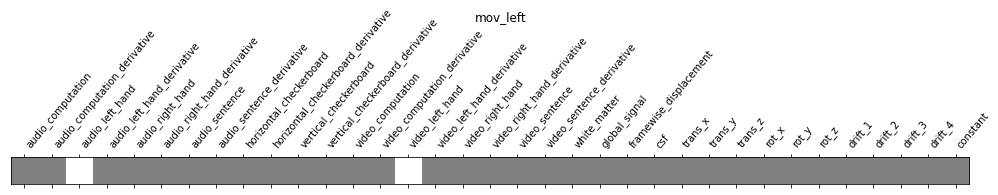

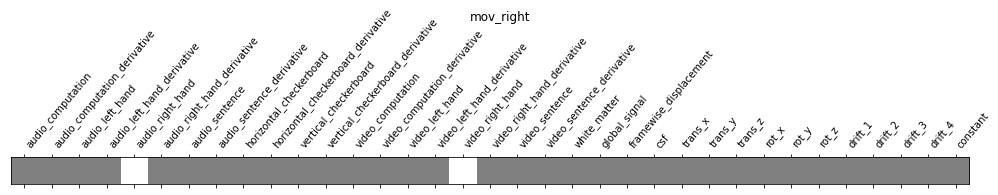

In [261]:
contrasts = make_localizer_contrasts(design_matrix)
from nilearn.plotting import plot_contrast_matrix
for key, values in contrasts.items():
    plot_contrast_matrix(values, design_matrix=design_matrix)
    plt.suptitle(key)

plt.show()

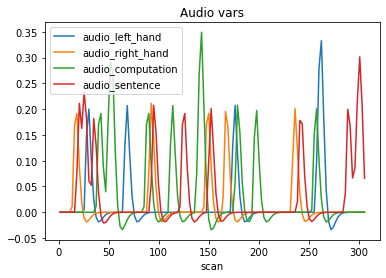

In [262]:
plt.plot(design_matrix['audio_left_hand'], label='audio_left_hand')
plt.plot(design_matrix['audio_right_hand'], label='audio_right_hand')
plt.plot(design_matrix['audio_computation'], label='audio_computation')
plt.plot(design_matrix['audio_sentence'], label='audio_sentence')
plt.xlabel('scan')
plt.title('Audio vars')
plt.legend(loc='upper left')
plt.show()

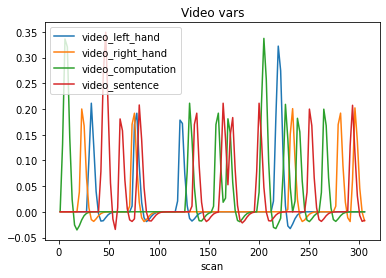

In [263]:
plt.plot(design_matrix['video_left_hand'], label='video_left_hand')
plt.plot(design_matrix['video_right_hand'], label='video_right_hand')
plt.plot(design_matrix['video_computation'], label='video_computation')
plt.plot(design_matrix['video_sentence'], label='video_sentence')
plt.xlabel('scan')
plt.title('Video vars')
plt.legend(loc='upper left')
plt.show()

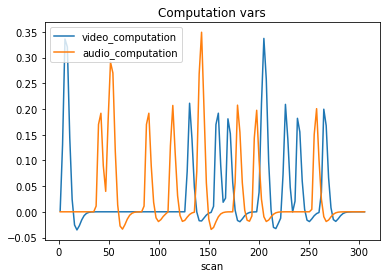

In [264]:
plt.plot(design_matrix['video_computation'], label='video_computation')
plt.plot(design_matrix['audio_computation'], label='audio_computation')
plt.xlabel('scan')
plt.title('Computation vars')
plt.legend(loc='upper left')
plt.show()

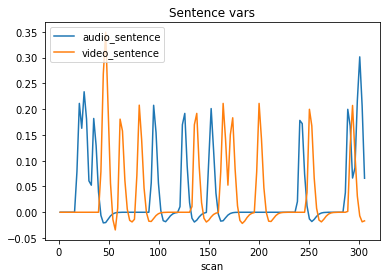

In [265]:
plt.plot(design_matrix['audio_sentence'], label='audio_sentence')
plt.plot(design_matrix['video_sentence'], label='video_sentence')
plt.xlabel('scan')
plt.title('Sentence vars')
plt.legend(loc='upper left')
plt.show()

# Mov_left

In [266]:
eff_map = fmri_glm.compute_contrast(contrasts['mov_left'], output_type='effect_size')

In [267]:
from nilearn.glm.thresholding import threshold_stats_img
z_map = fmri_glm.compute_contrast(contrasts['mov_left'], output_type='z_score')
clean_map, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr', cluster_threshold=8)


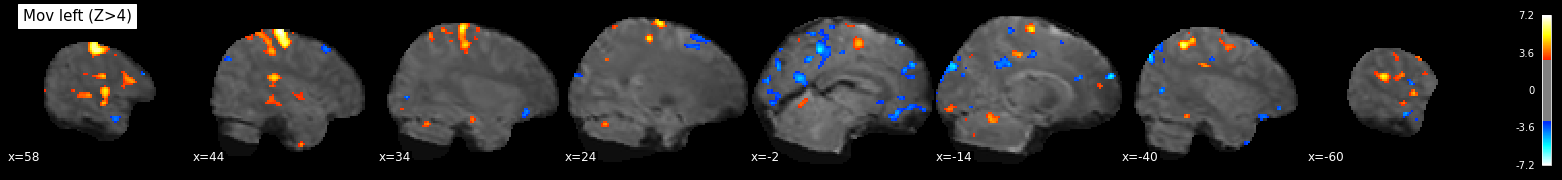

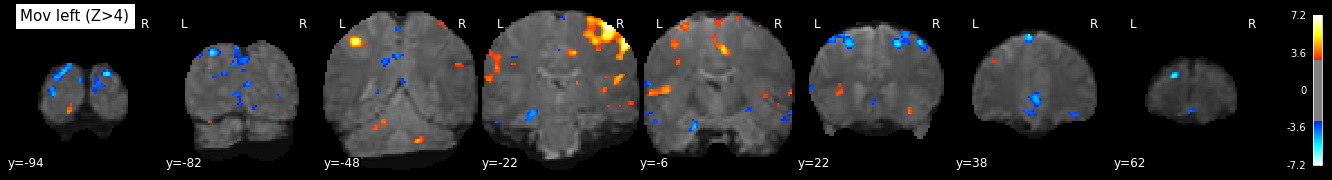

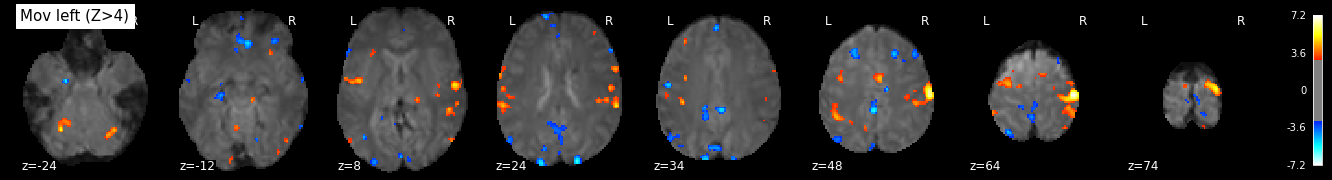

In [268]:
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title='Mov left (Z>4)')
    plt.show()

# Mov_right

In [269]:
eff_map = fmri_glm.compute_contrast(contrasts['mov_right'], output_type='effect_size')

In [270]:
z_map = fmri_glm.compute_contrast(contrasts['mov_right'], output_type='z_score')
clean_map, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr', cluster_threshold=8)

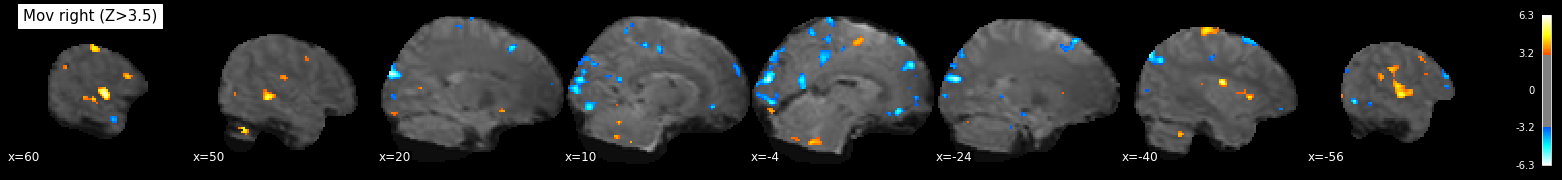

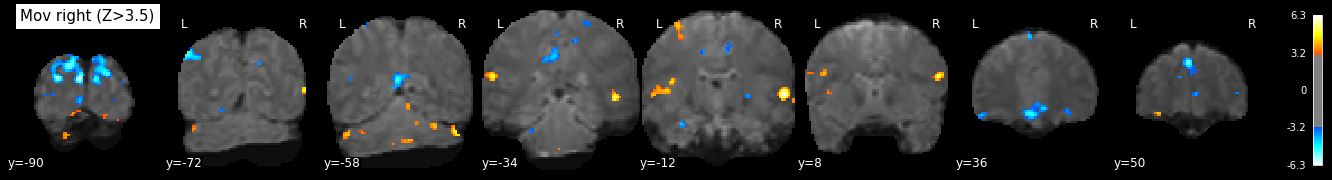

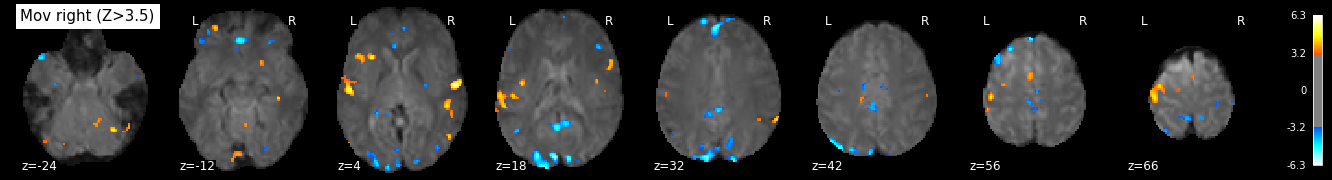

In [271]:
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title='Mov right (Z>3.5)')
    plt.show()

# Audio

In [272]:
eff_map = fmri_glm.compute_contrast(contrasts['audio'], output_type='effect_size')

In [273]:
z_map = fmri_glm.compute_contrast(contrasts['audio'], output_type='z_score')
clean_map, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr', cluster_threshold=8)

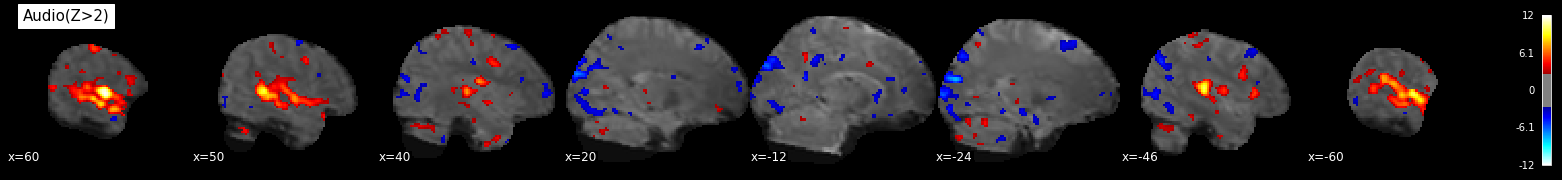

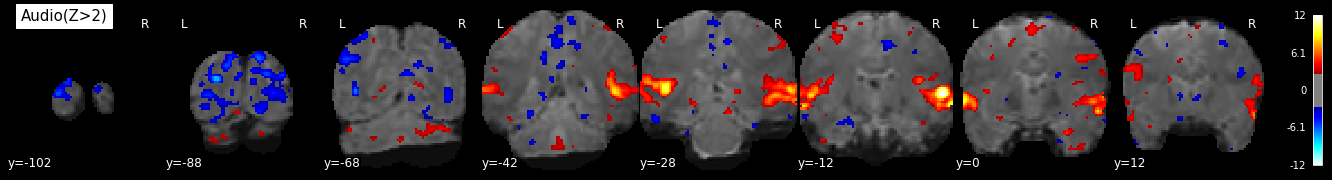

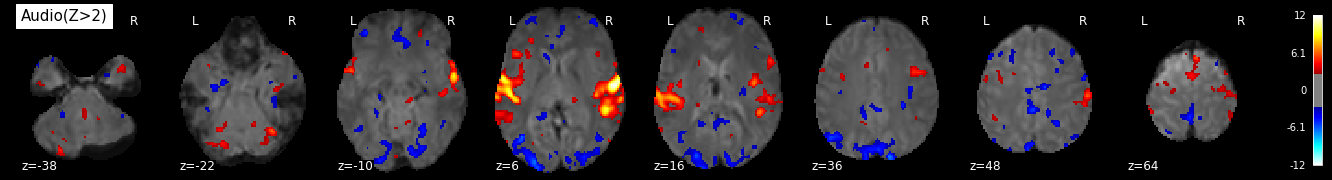

In [274]:
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title='Audio(Z>2)')
    plt.show()

# Video

In [275]:
eff_map = fmri_glm.compute_contrast(contrasts['video'], output_type='effect_size')

In [276]:
z_map = fmri_glm.compute_contrast(contrasts['video'], output_type='z_score')
clean_map, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr', cluster_threshold=8)

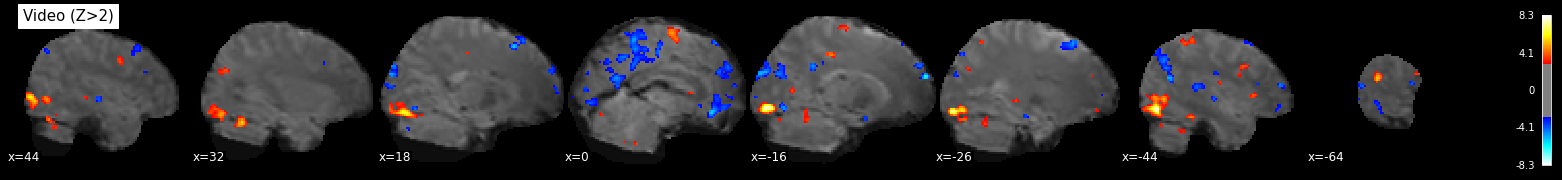

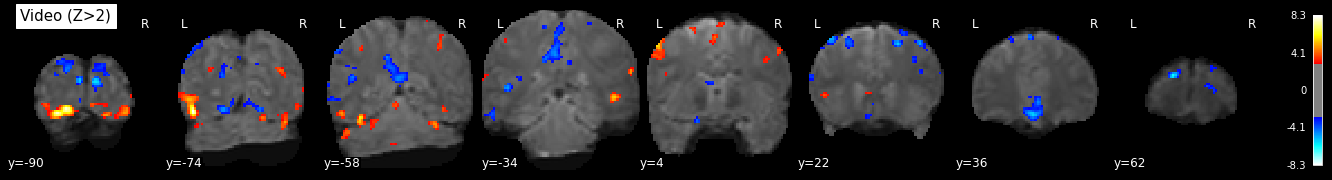

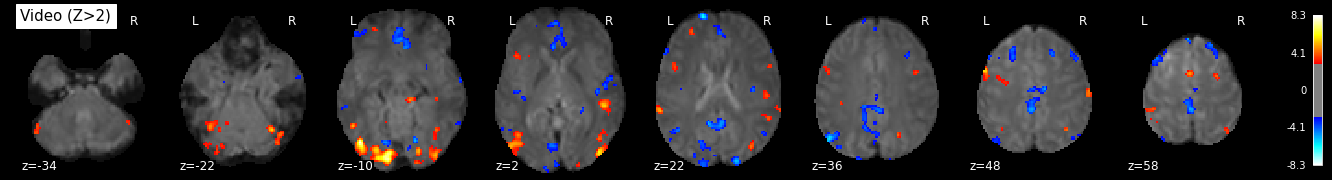

In [277]:
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title='Video (Z>2)')
    plt.show()

# Computation

In [278]:
eff_map = fmri_glm.compute_contrast(contrasts['computation'], output_type='effect_size')

In [279]:
z_map = fmri_glm.compute_contrast(contrasts['computation'], output_type='z_score')
clean_map, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr', cluster_threshold=8)

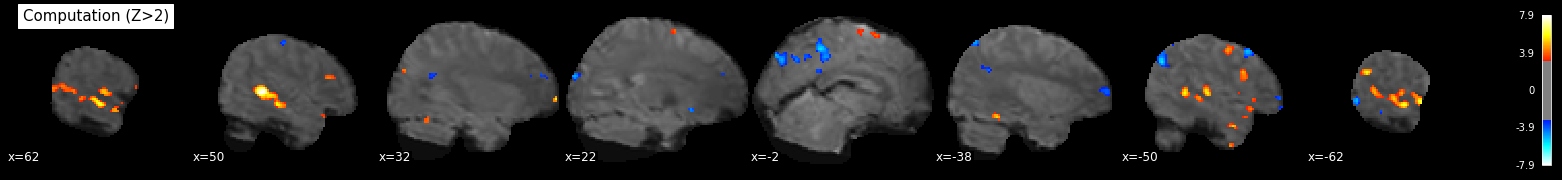

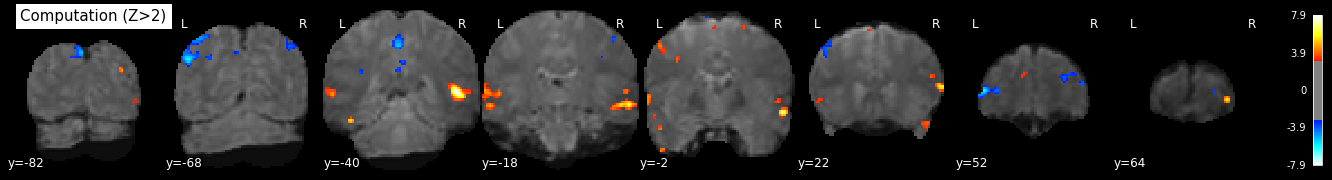

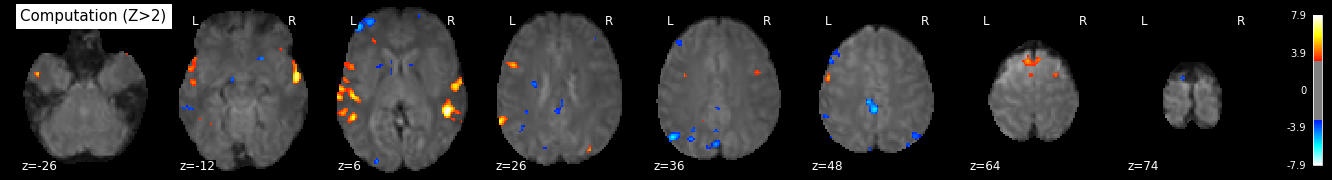

In [280]:
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title='Computation (Z>2)')
    plt.show()

# Sentence

In [281]:
eff_map = fmri_glm.compute_contrast(contrasts['sentences'], output_type='effect_size')

In [282]:
z_map = fmri_glm.compute_contrast(contrasts['sentences'], output_type='z_score')
clean_map, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr', cluster_threshold=8)

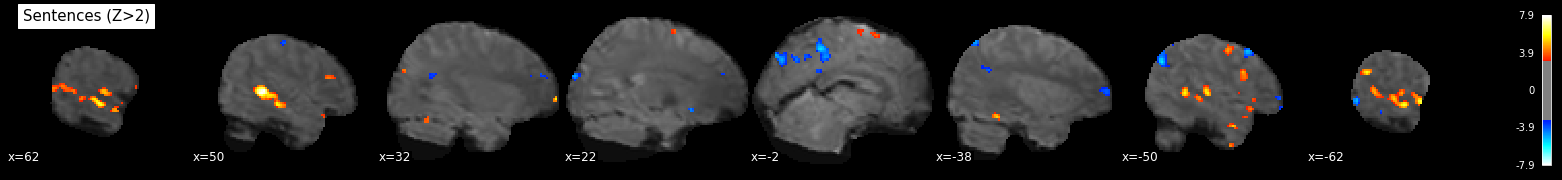

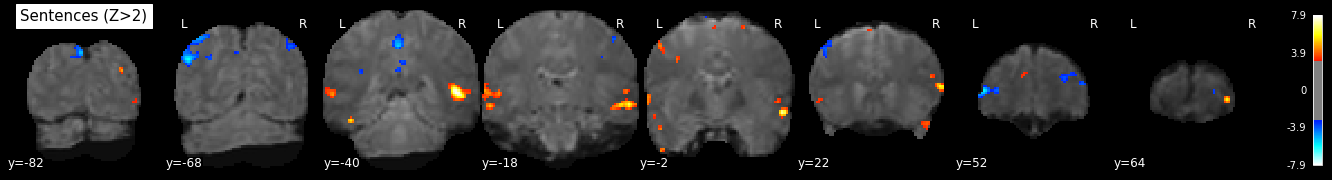

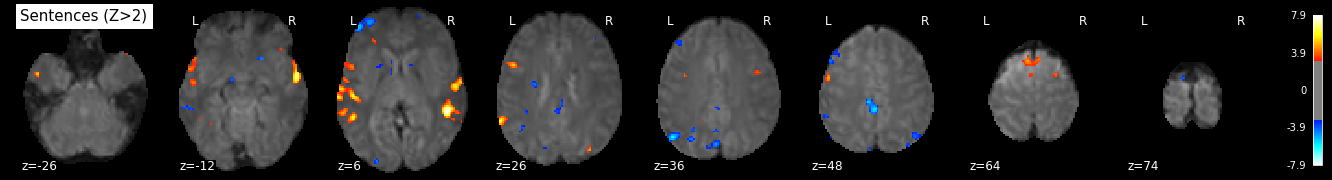

In [283]:
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title='Sentences (Z>2)')
    plt.show()

# Left - Right button press

In [284]:
eff_map = fmri_glm.compute_contrast(contrasts['left - right button press'], output_type='effect_size')

In [285]:
z_map = fmri_glm.compute_contrast(contrasts['left - right button press'], output_type='z_score')
clean_map, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr', cluster_threshold=8)

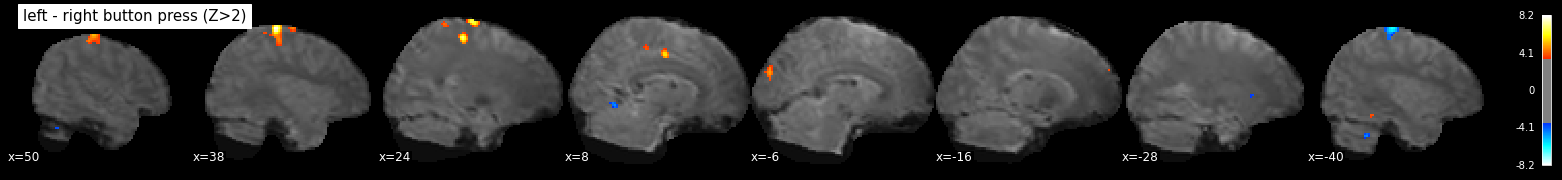

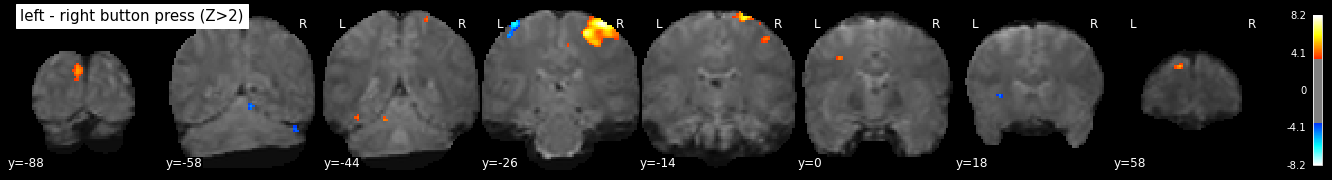

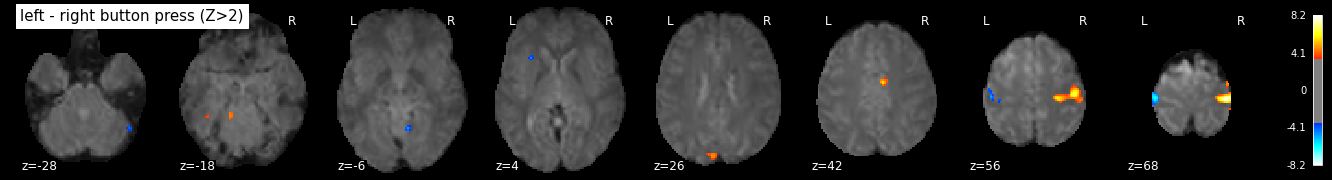

In [286]:
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title='left - right button press (Z>2)')
    plt.show()

# Right - Left button press

In [287]:
eff_map = fmri_glm.compute_contrast(contrasts['right - left button press'], output_type='effect_size')

In [288]:
z_map = fmri_glm.compute_contrast(contrasts['right - left button press'], output_type='z_score')
clean_map, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr', cluster_threshold=8)

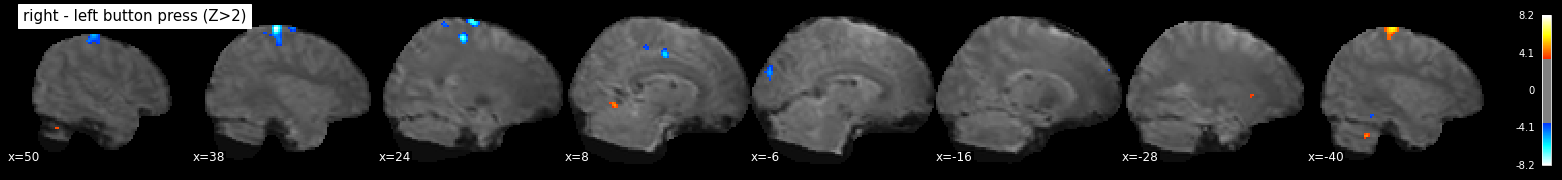

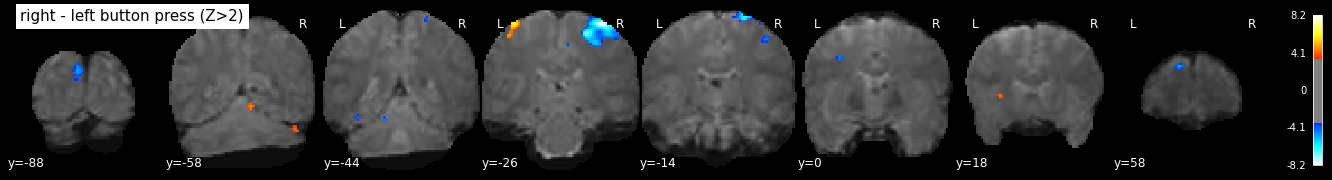

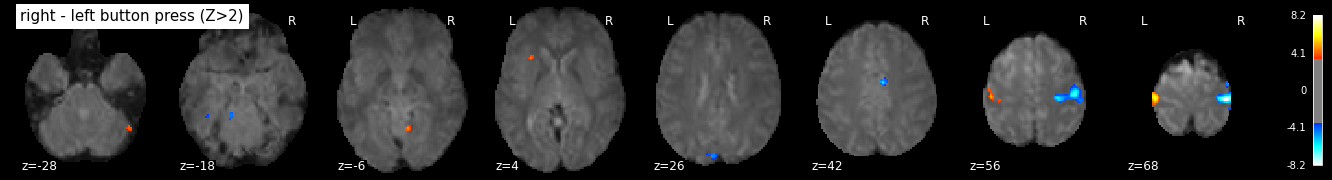

In [289]:
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title='right - left button press (Z>2)')
    plt.show()

# Audio - Video

In [290]:
eff_map = fmri_glm.compute_contrast(contrasts['audio - video'], output_type='effect_size')

In [291]:
z_map = fmri_glm.compute_contrast(contrasts['audio - video'], output_type='z_score')
clean_map, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr', cluster_threshold=8)

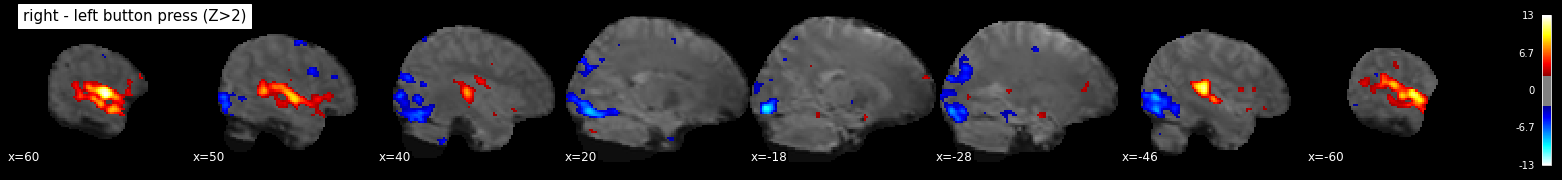

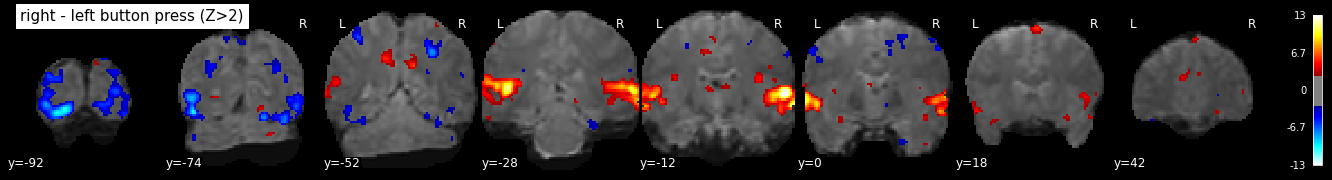

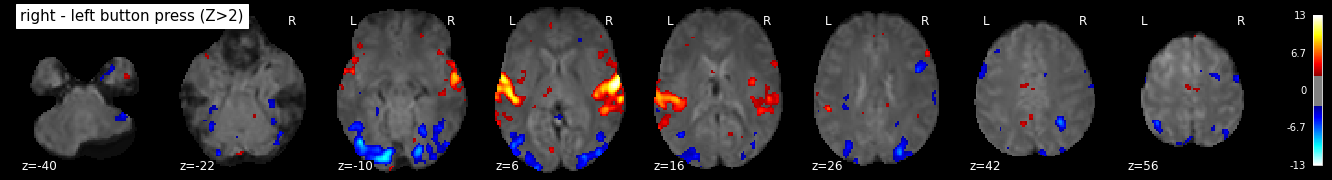

In [292]:
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title='right - left button press (Z>2)')
    plt.show()

# Computation - Sentences

In [293]:
eff_map = fmri_glm.compute_contrast(contrasts['computation - sentences'], output_type='effect_size')

In [294]:
z_map = fmri_glm.compute_contrast(contrasts['computation - sentences'], output_type='z_score')
clean_map, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr', cluster_threshold=8)

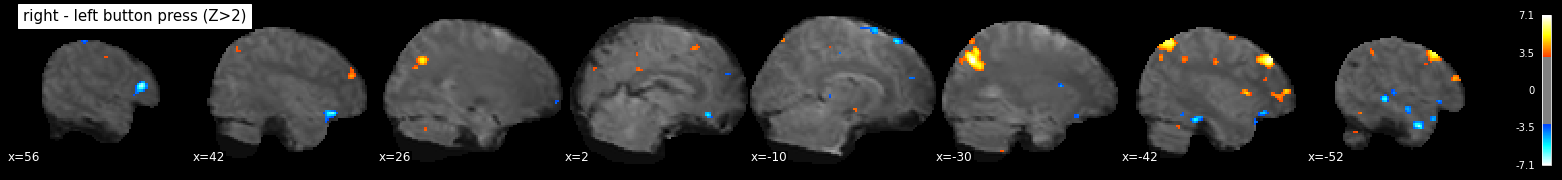

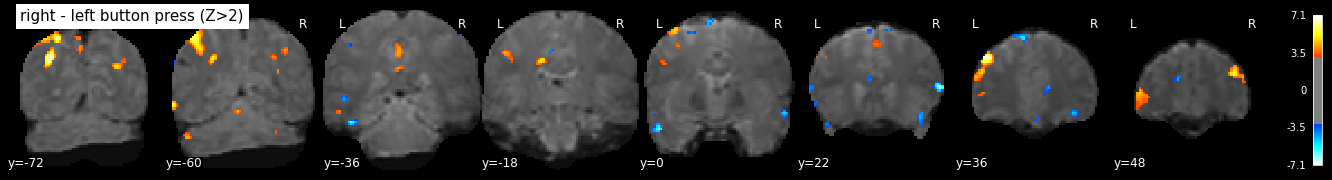

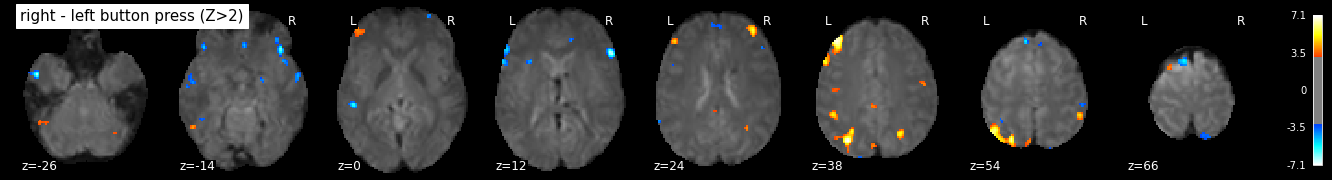

In [295]:
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title='right - left button press (Z>2)')
    plt.show()

# Horizontal-Vertical

In [296]:
eff_map = fmri_glm.compute_contrast(contrasts['horizontal-vertical'], output_type='effect_size')

In [297]:
z_map = fmri_glm.compute_contrast(contrasts['horizontal-vertical'], output_type='z_score')
clean_map, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr', cluster_threshold=8)

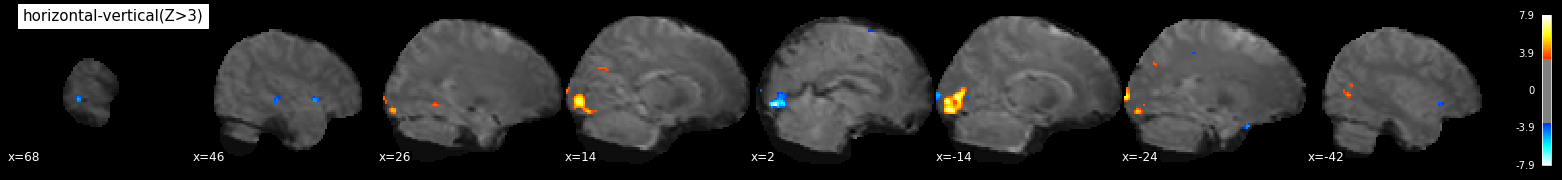

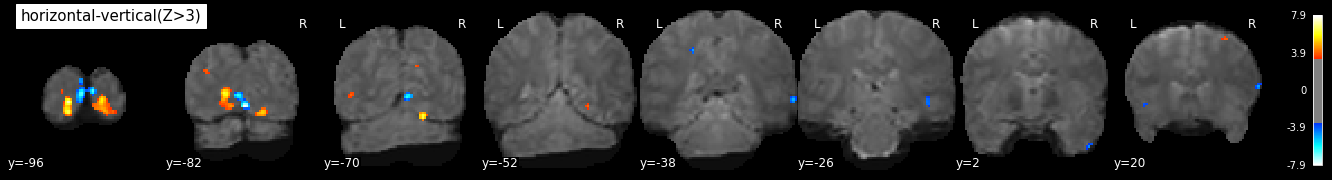

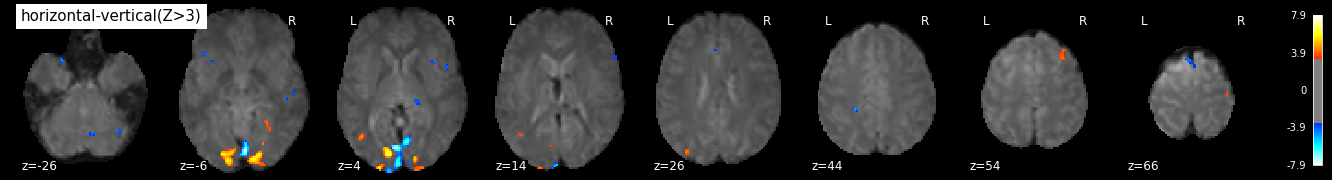

In [298]:
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title='horizontal-vertical(Z>3)')
    plt.show()